# Wine Quality Preprocessing (Oversampling)

Made by: Anthony Kevin Oktavius

Library Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import klib
import plotly
import plotly.express as px
import shap
import hyperopt
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In this section, I'm going to look at Wine Quality Oversampling Technique. In our case, we will use 3 types of oversampling technique, which are:

* Random Over Sampling
* SMOTE
* ADASYN

Dataset Import

In [2]:
red_wine_dataset = pd.read_csv("winequality-red.csv", sep = ';')
red_wine_dataset.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [3]:
white_wine_dataset = pd.read_csv("winequality-white.csv", sep = ';')
white_wine_dataset.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6

Define All Fields

In [4]:
fixed_acidity_field = "fixed acidity"
volatile_acidity_field = "volatile acidity"
citric_acid_field = "citric acid"
residual_sugar_field = "residual sugar"
chlorides_field = "chlorides"
free_sulfur_dioxide_field = "free sulfur dioxide"
total_sulfur_dioxide_field = "total sulfur dioxide"
density_field = "density"
ph_field = "pH"
sulphates_field = "sulphates"
alcohol_field = "alcohol"
quality_field = "quality"

Define Categorical and Numerical Features

In [5]:
numerical_features = [fixed_acidity_field, volatile_acidity_field, citric_acid_field,
                      residual_sugar_field, chlorides_field, free_sulfur_dioxide_field,
                      total_sulfur_dioxide_field, density_field, ph_field, sulphates_field]
categorical_features = [quality_field]

Define Target And Label Fields

In [6]:
labels = numerical_features.copy()
target = categorical_features.copy()

In [7]:
x_white = white_wine_dataset[labels]
x_red = red_wine_dataset[labels]

y_white = white_wine_dataset[target]
y_red = red_wine_dataset[target]

## Random Over Sampling

![Random Oversampling](https://miro.medium.com/max/375/1*aKJJOozIlVVH1gT-4rYy4w.png)

Image Source: https://miro.medium.com/max/375/1*aKJJOozIlVVH1gT-4rYy4w.png

![Random Oversampling Plot](https://imbalanced-learn.org/stable/_images/sphx_glr_plot_comparison_over_sampling_002.png)

Image Source: https://imbalanced-learn.org/stable/_images/sphx_glr_plot_comparison_over_sampling_002.png

Random Oversampling includes duplicating examples from minority classes. The duplicated minority examples will then be added to the original dataset, so it allows the data to be selected again.

This technique is effective when we'd like to normalize skewed distributions (mean and standard deviation are not 0). However, in some cases, doing this technique can cause the algorithm to overfit the minority class, since the same data row can be duplicated again.

In [8]:
random_over_sampler = RandomOverSampler()
x_red_random_oversampling, y_red_random_oversampling = random_over_sampler.fit_resample(x_red, y_red)
x_white_random_oversampling, y_white_random_oversampling = random_over_sampler.fit_resample(x_white, y_white)

## SMOTE

![SMOTE](https://miro.medium.com/max/1400/1*CG712DHQL_ZMS3gAEGd_5w.jpeg)

Image Source: https://miro.medium.com/max/1400/1*CG712DHQL_ZMS3gAEGd_5w.jpeg

Unlike Random Over Sampling where we copy the values from the actual dataset, SMOTE creates new synthetic observations/ new data points.

Here are the summary steps on SMOTE Process:
* Plot the data points.
* Identify feature vector and its nearest neighbour. In this case, we're using K-Nearest Neighbors.
* Take the linear distance difference between the two
* Multiply the difference with a random number between 0 and 1
* Identify a new point on the line segment by adding the random number to feature vector
* Repeat the process for identified feature vectors, until our defined data points that we’d like to create.

In [9]:
smote = SMOTE(k_neighbors=4)
x_red_smote, y_red_smote = smote.fit_resample(x_red, y_red)
x_white_smote, y_white_smote = smote.fit_resample(x_white, y_white)

## ADASYN

The comparison between ADASYN and SMOTE can be seen in this research paper: https://www.diva-portal.org/smash/get/diva2:1519153/FULLTEXT01.pdf.

![ADASYN](https://miro.medium.com/max/601/1*dOHFA1ffNyKbQ55Vw0PNzA.png)

Image Source: https://miro.medium.com/max/601/1*dOHFA1ffNyKbQ55Vw0PNzA.png

ADASYN stands for Adaptive Synthetic Algorithm.

ADASYN works similar to SMOTE. Below are some characteristics on ADASYN:

* ADASYN algorithm works on providing more synthetic data on harder-to-learn than easier-to-learn data.
  
* ADASYN generates synthetic observations along a straight line between a minority class observation and k-nearest minority class neighbor.

Here's how ADASYN works:

* Calculate the degree of class imbalance: d = $\frac{m_s}{m_l}$

  Where d will be between 0 and 1.
* If d < $d_{th}$, where th is the defined threshold ratio: 
  
  * Calculate the number of synthetic data examples that needs to be generated from minority class.

  $G = (m_{l} - m_{s}) * \beta $

  Where $\beta$ can be either 0 or 1. $\beta$ represents the desired balance level after synthetic data generation (e.g. $\beta$ = 1, then the data is fully balanced after synthetic data generation).

  * For each example $x_i$  $\epsilon$  minority class, find K nearest neighbors based on eucledian distance in N dimensional space.

  Calculate the ratio ${r_i}$, defined as:

  ${r_i} = $ ${\Delta}_i / K$

  Where: ${\Delta}_i$ is the number of examples in the K nearest neighbors of majority class. ${r_i}$ is equal to 0 or 1.

  * Normalize ${r_i}$ according to $\hat{r_i}$ = ${r_i}$ / $\sum_{i = 1}^{m_s} r_i$, so $\hat{r_i}$ is a density distribution (sum of $\hat{r_i}$ = 1).

  * Calculate the number of synthetic data examples that needs to be generated for minority example ${x_i}$.

    ${g_i}$ = $\hat{r_i}$ * G

    Where G is the total number of synthetic data examples that needs to be generated for minority class, as defined by equation (2).

  * For each minority classes in ${x_i}$, generate ${g_i}$ synthetic data examples.
    Looping from 1 to ${g_i}$:

      * Randomly choose 1 minority data example (${x_{xi}}$) from K nearest neighbors for data ${x_i}$.
      
      * Generate synthetic data example:
        ${s_i}$ = ${x_i} + (x_{zi} - x_i) * \lambda$
        
        $x_{zi} - x_i$ represents different vector in dimensional spaces and $\lambda$ is a random number either 0 or 1.



In [10]:
adasyn = ADASYN(n_neighbors=4)
x_red_adasyn, y_red_adasyn = smote.fit_resample(x_red, y_red)
x_white_adasyn, y_white_adasyn = smote.fit_resample(x_white, y_white)

In [14]:
oversampling_technique_names = ["Random Oversampling", "SMOTE", "ADASYN"]

red_wine_oversampling_df = [
    x_red_random_oversampling, 
    x_red_smote, 
    x_red_adasyn,
]

white_wine_oversampling_df = [
    x_white_random_oversampling,
    x_white_smote,
    x_white_adasyn
]

# Data Visualization

To examine the results, let's compare the result between all oversampling techniques above.

Red Wine

Random Oversampling


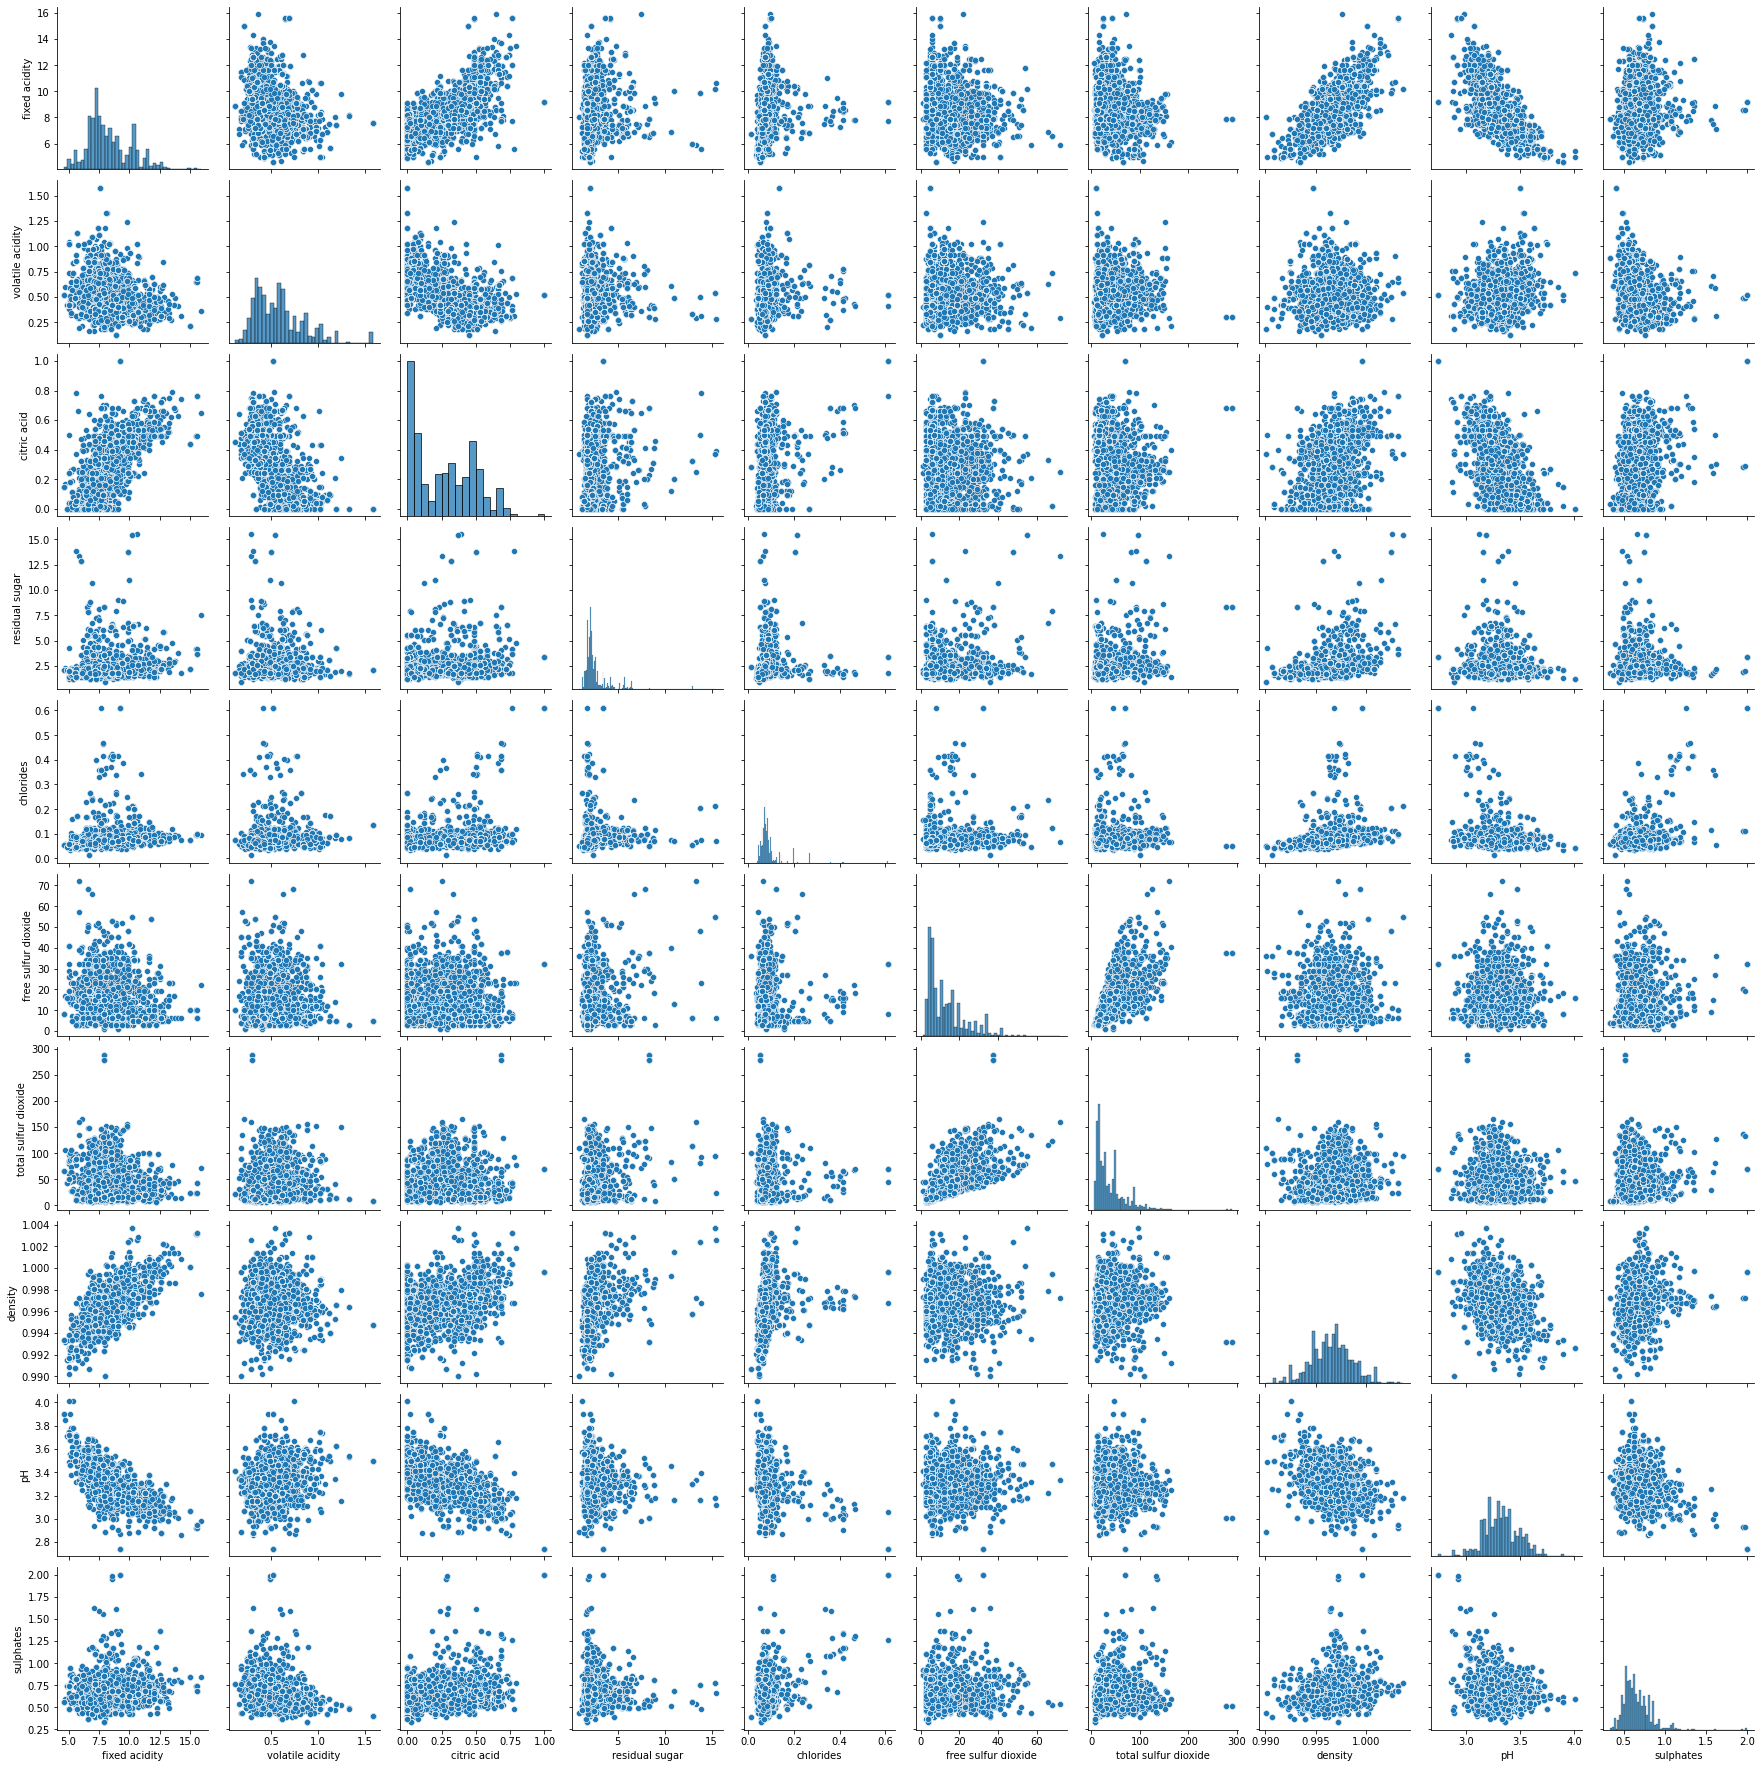

SMOTE


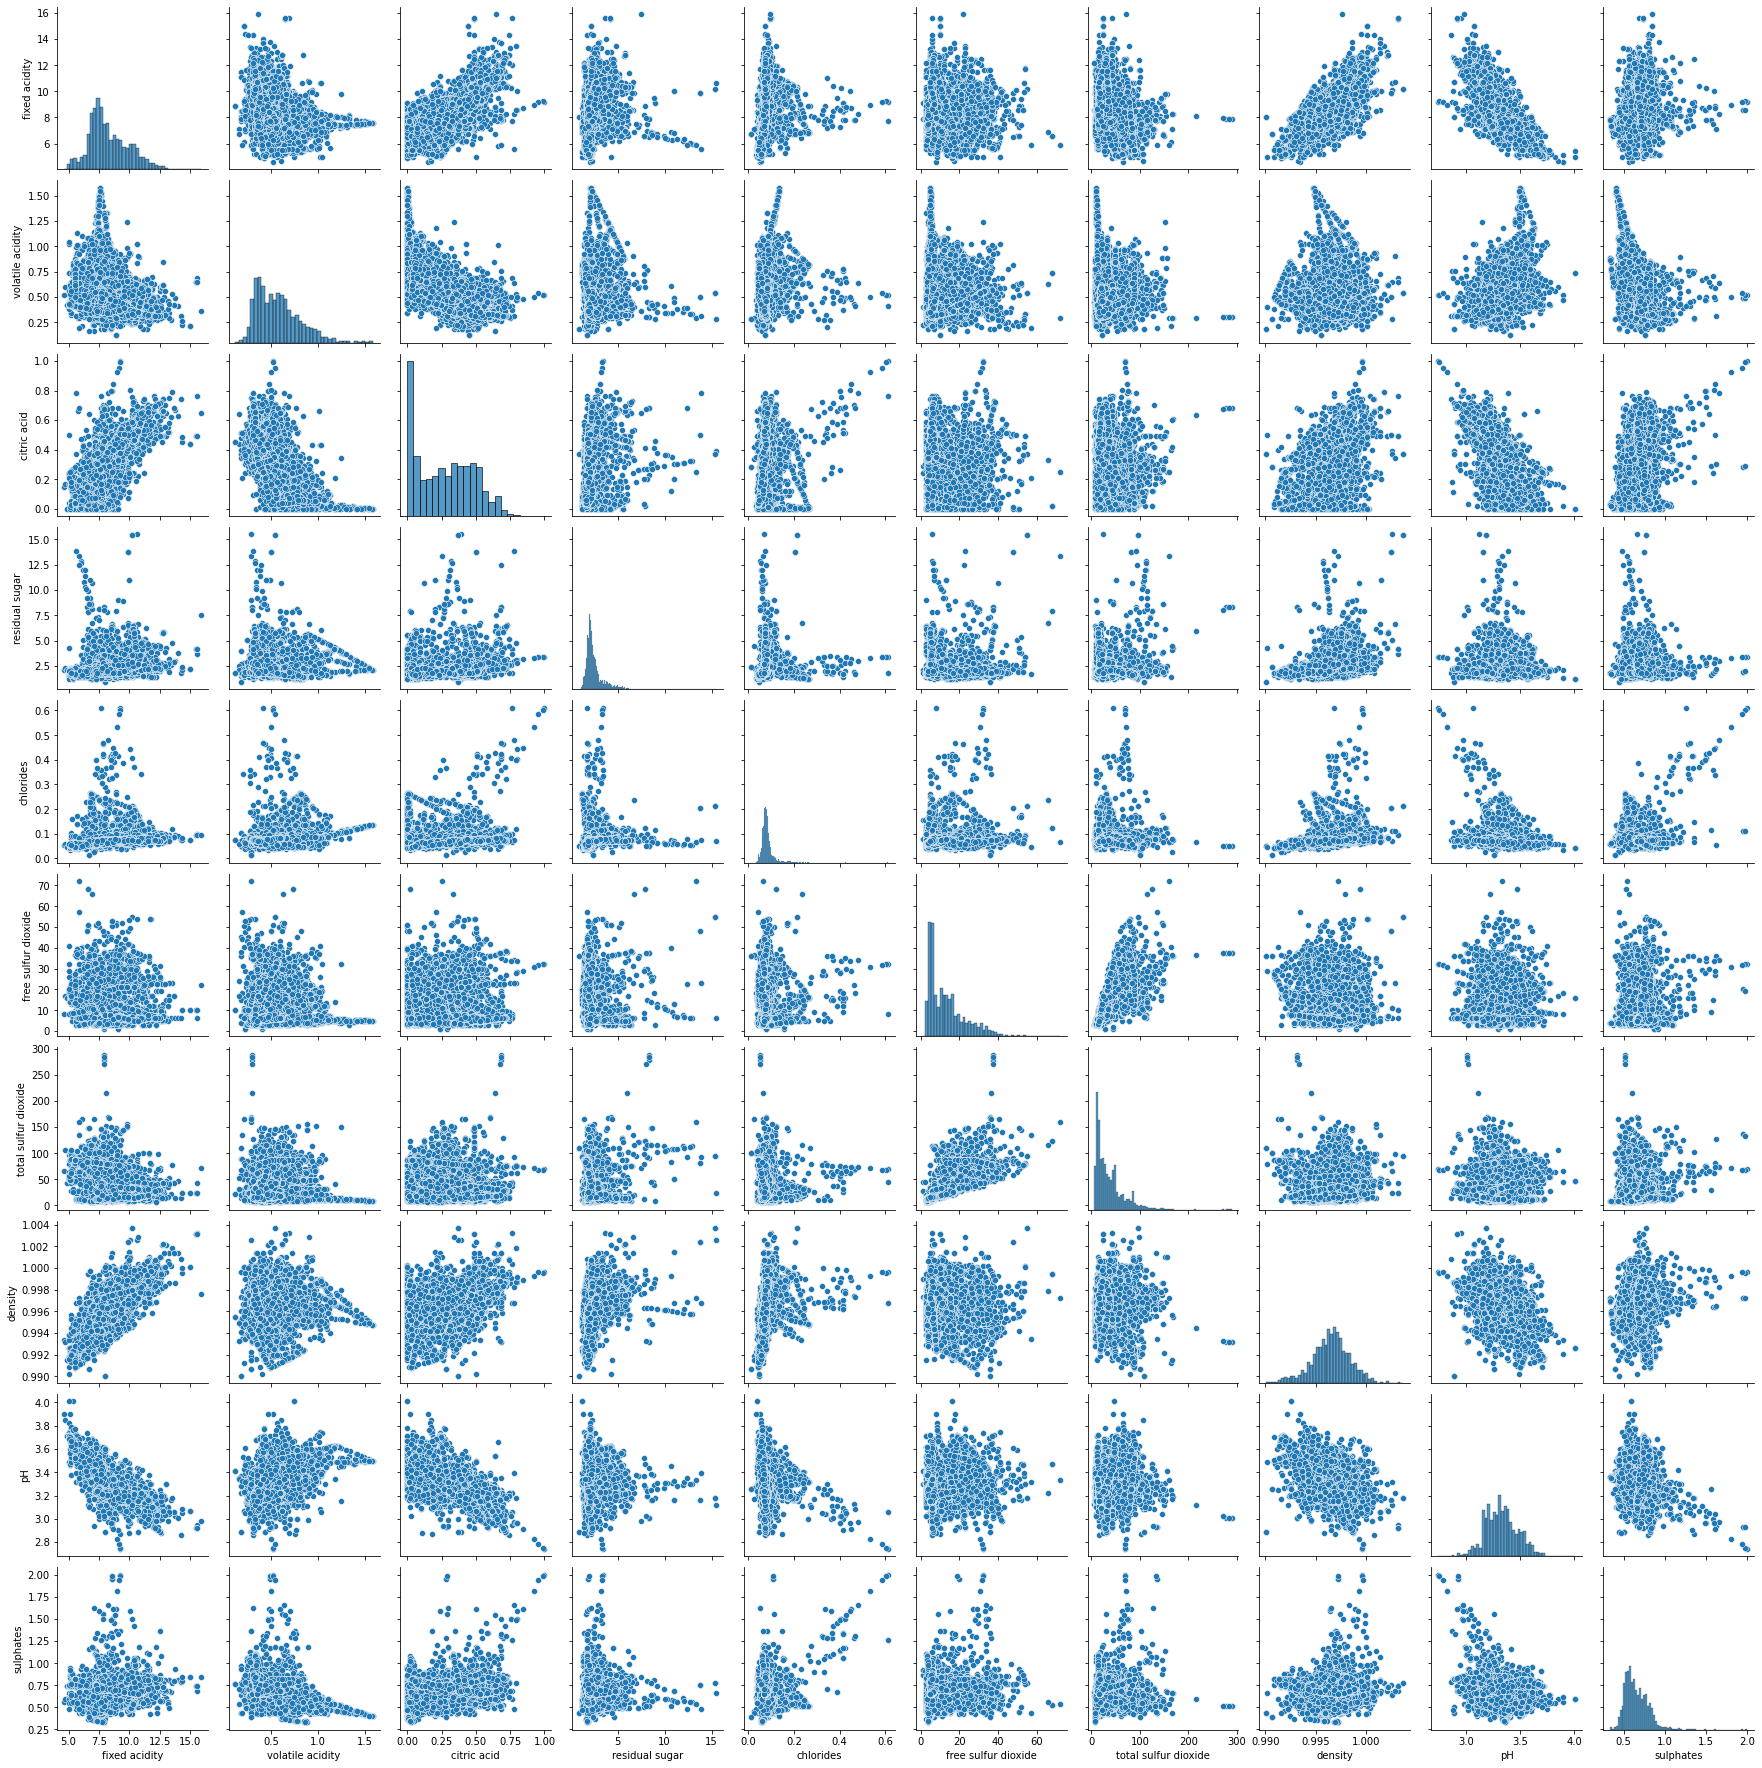

ADASYN


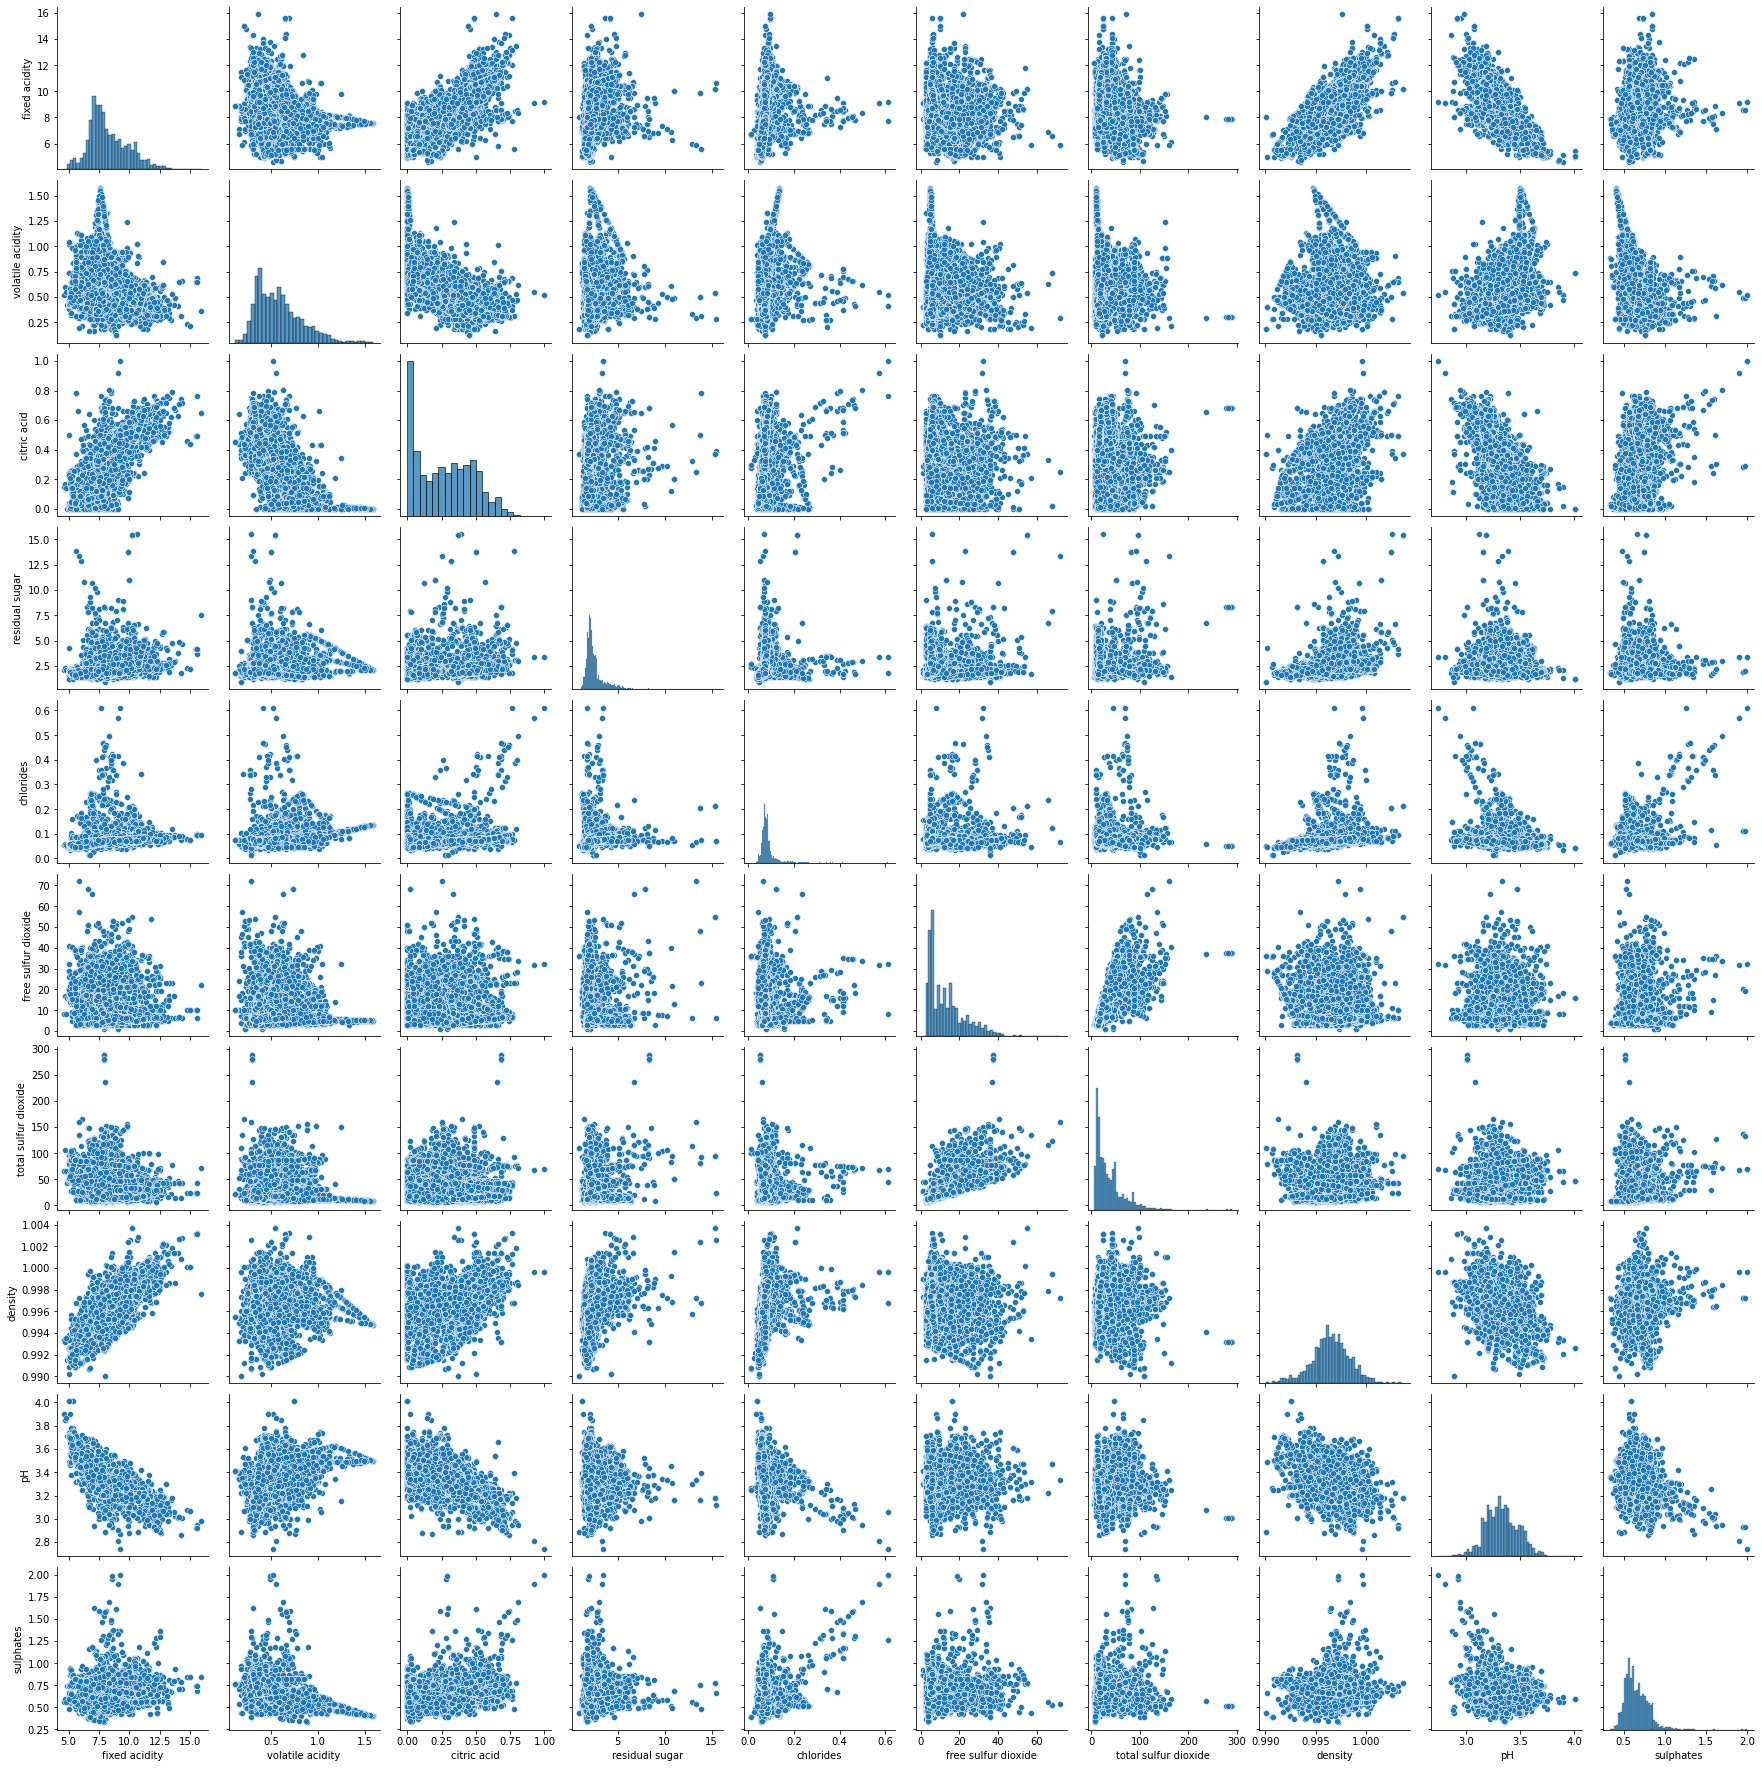

In [18]:
for index, df in enumerate(red_wine_oversampling_df):
    print(oversampling_technique_names[index])
    sns.pairplot(df)
    plt.show()

White Wine

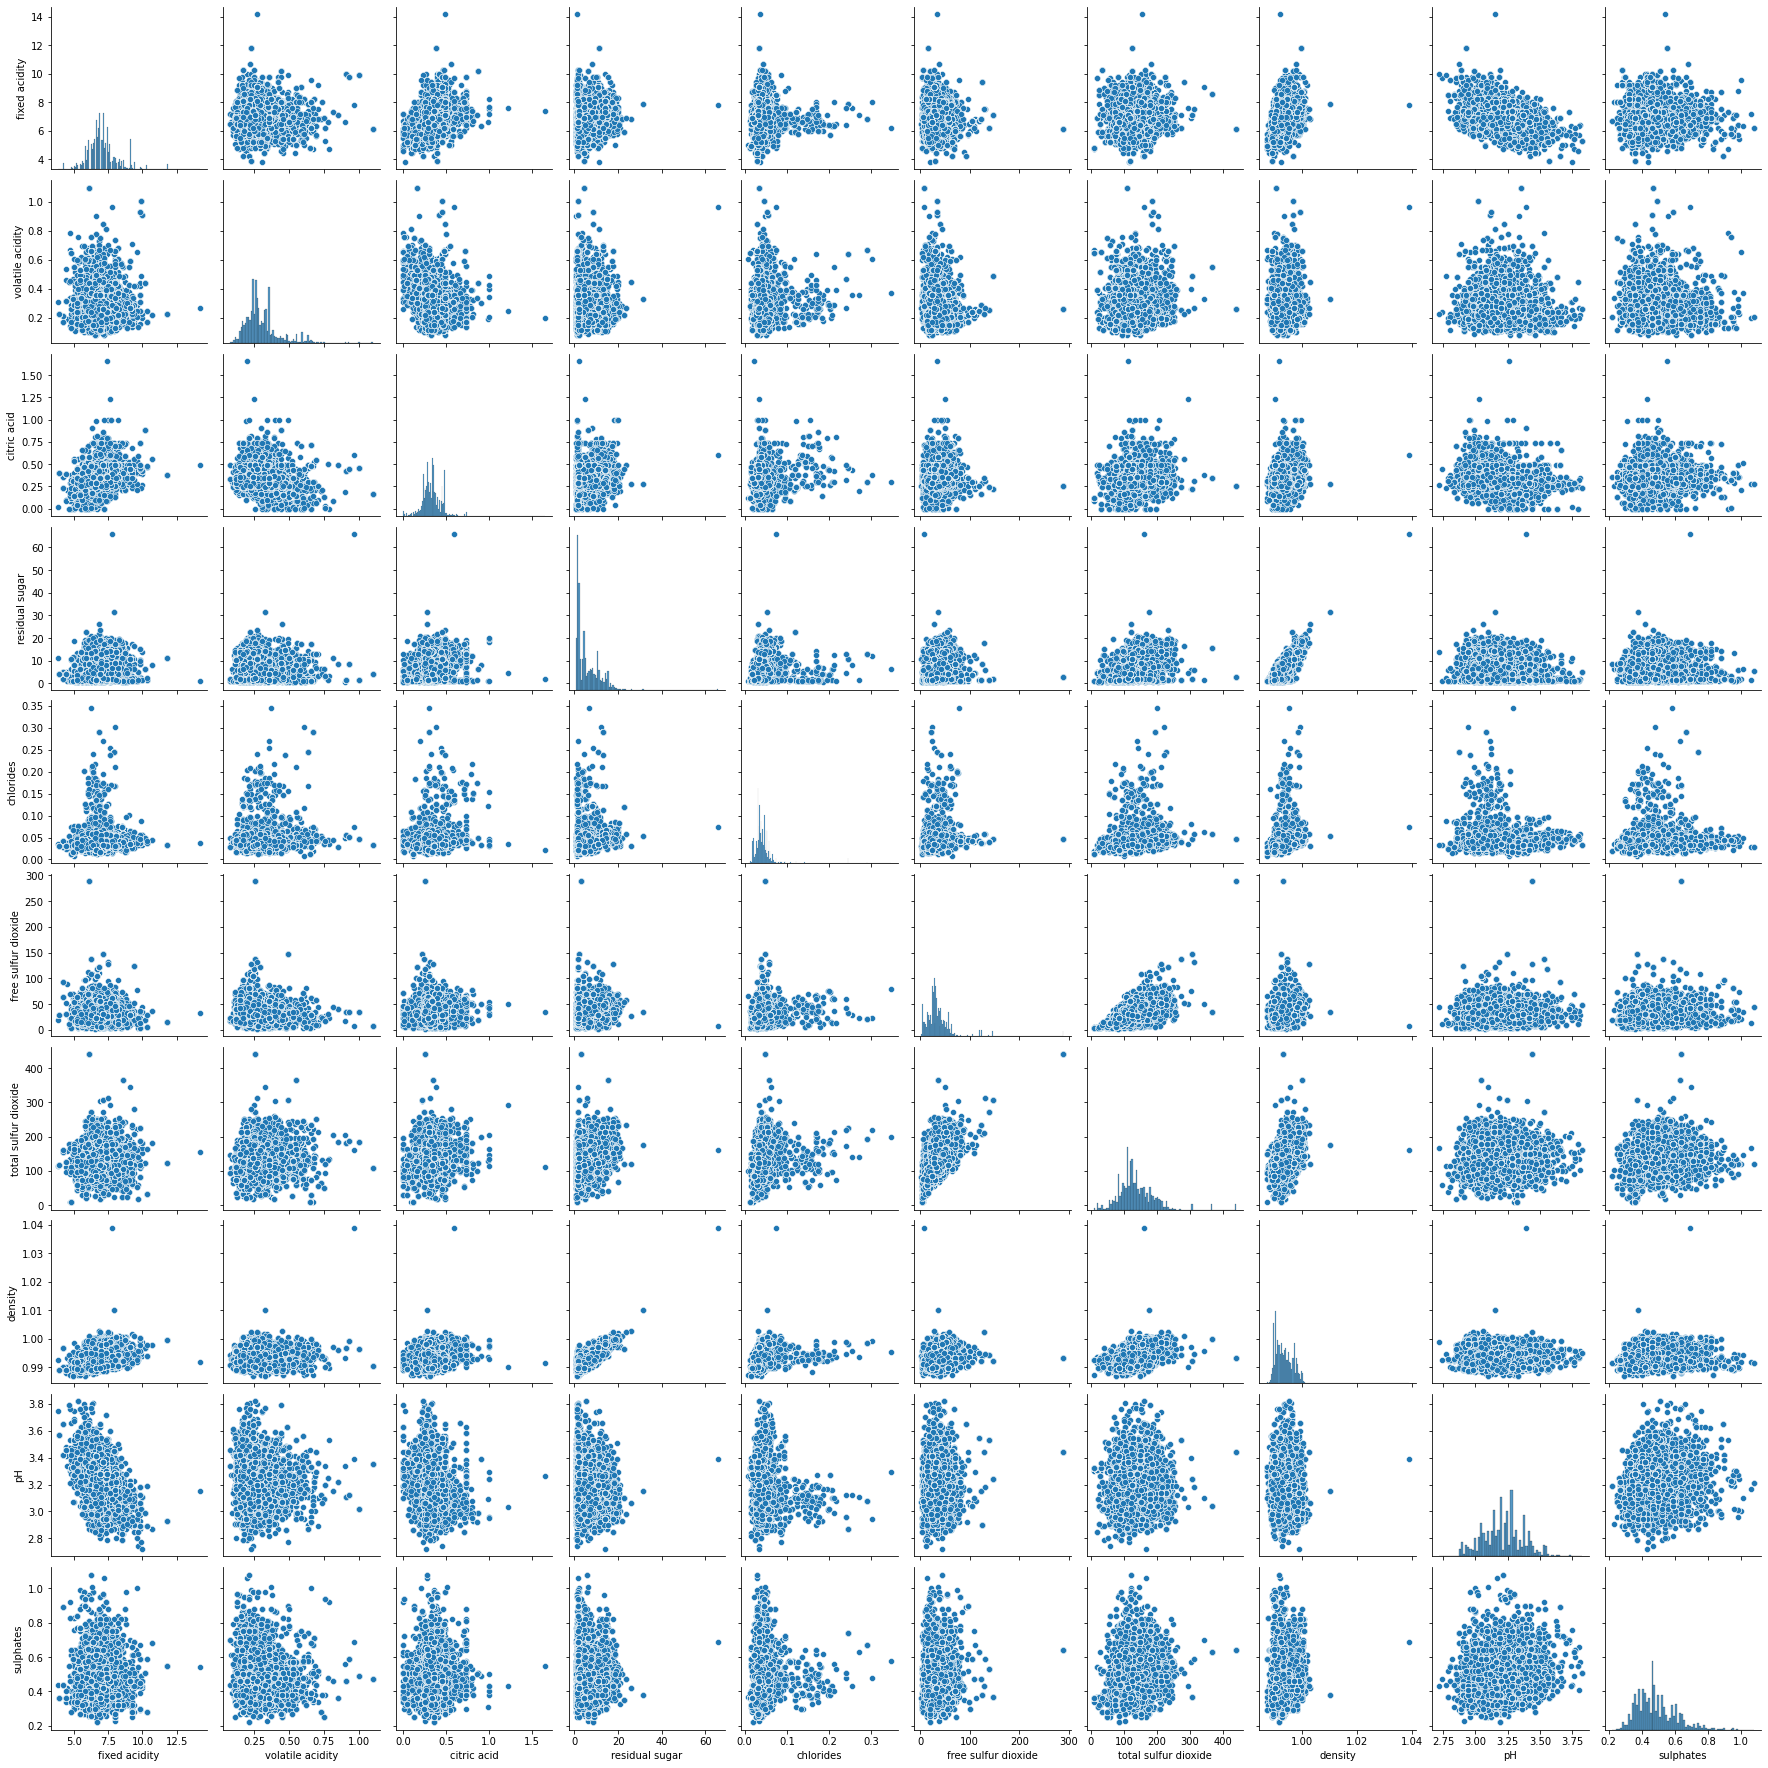

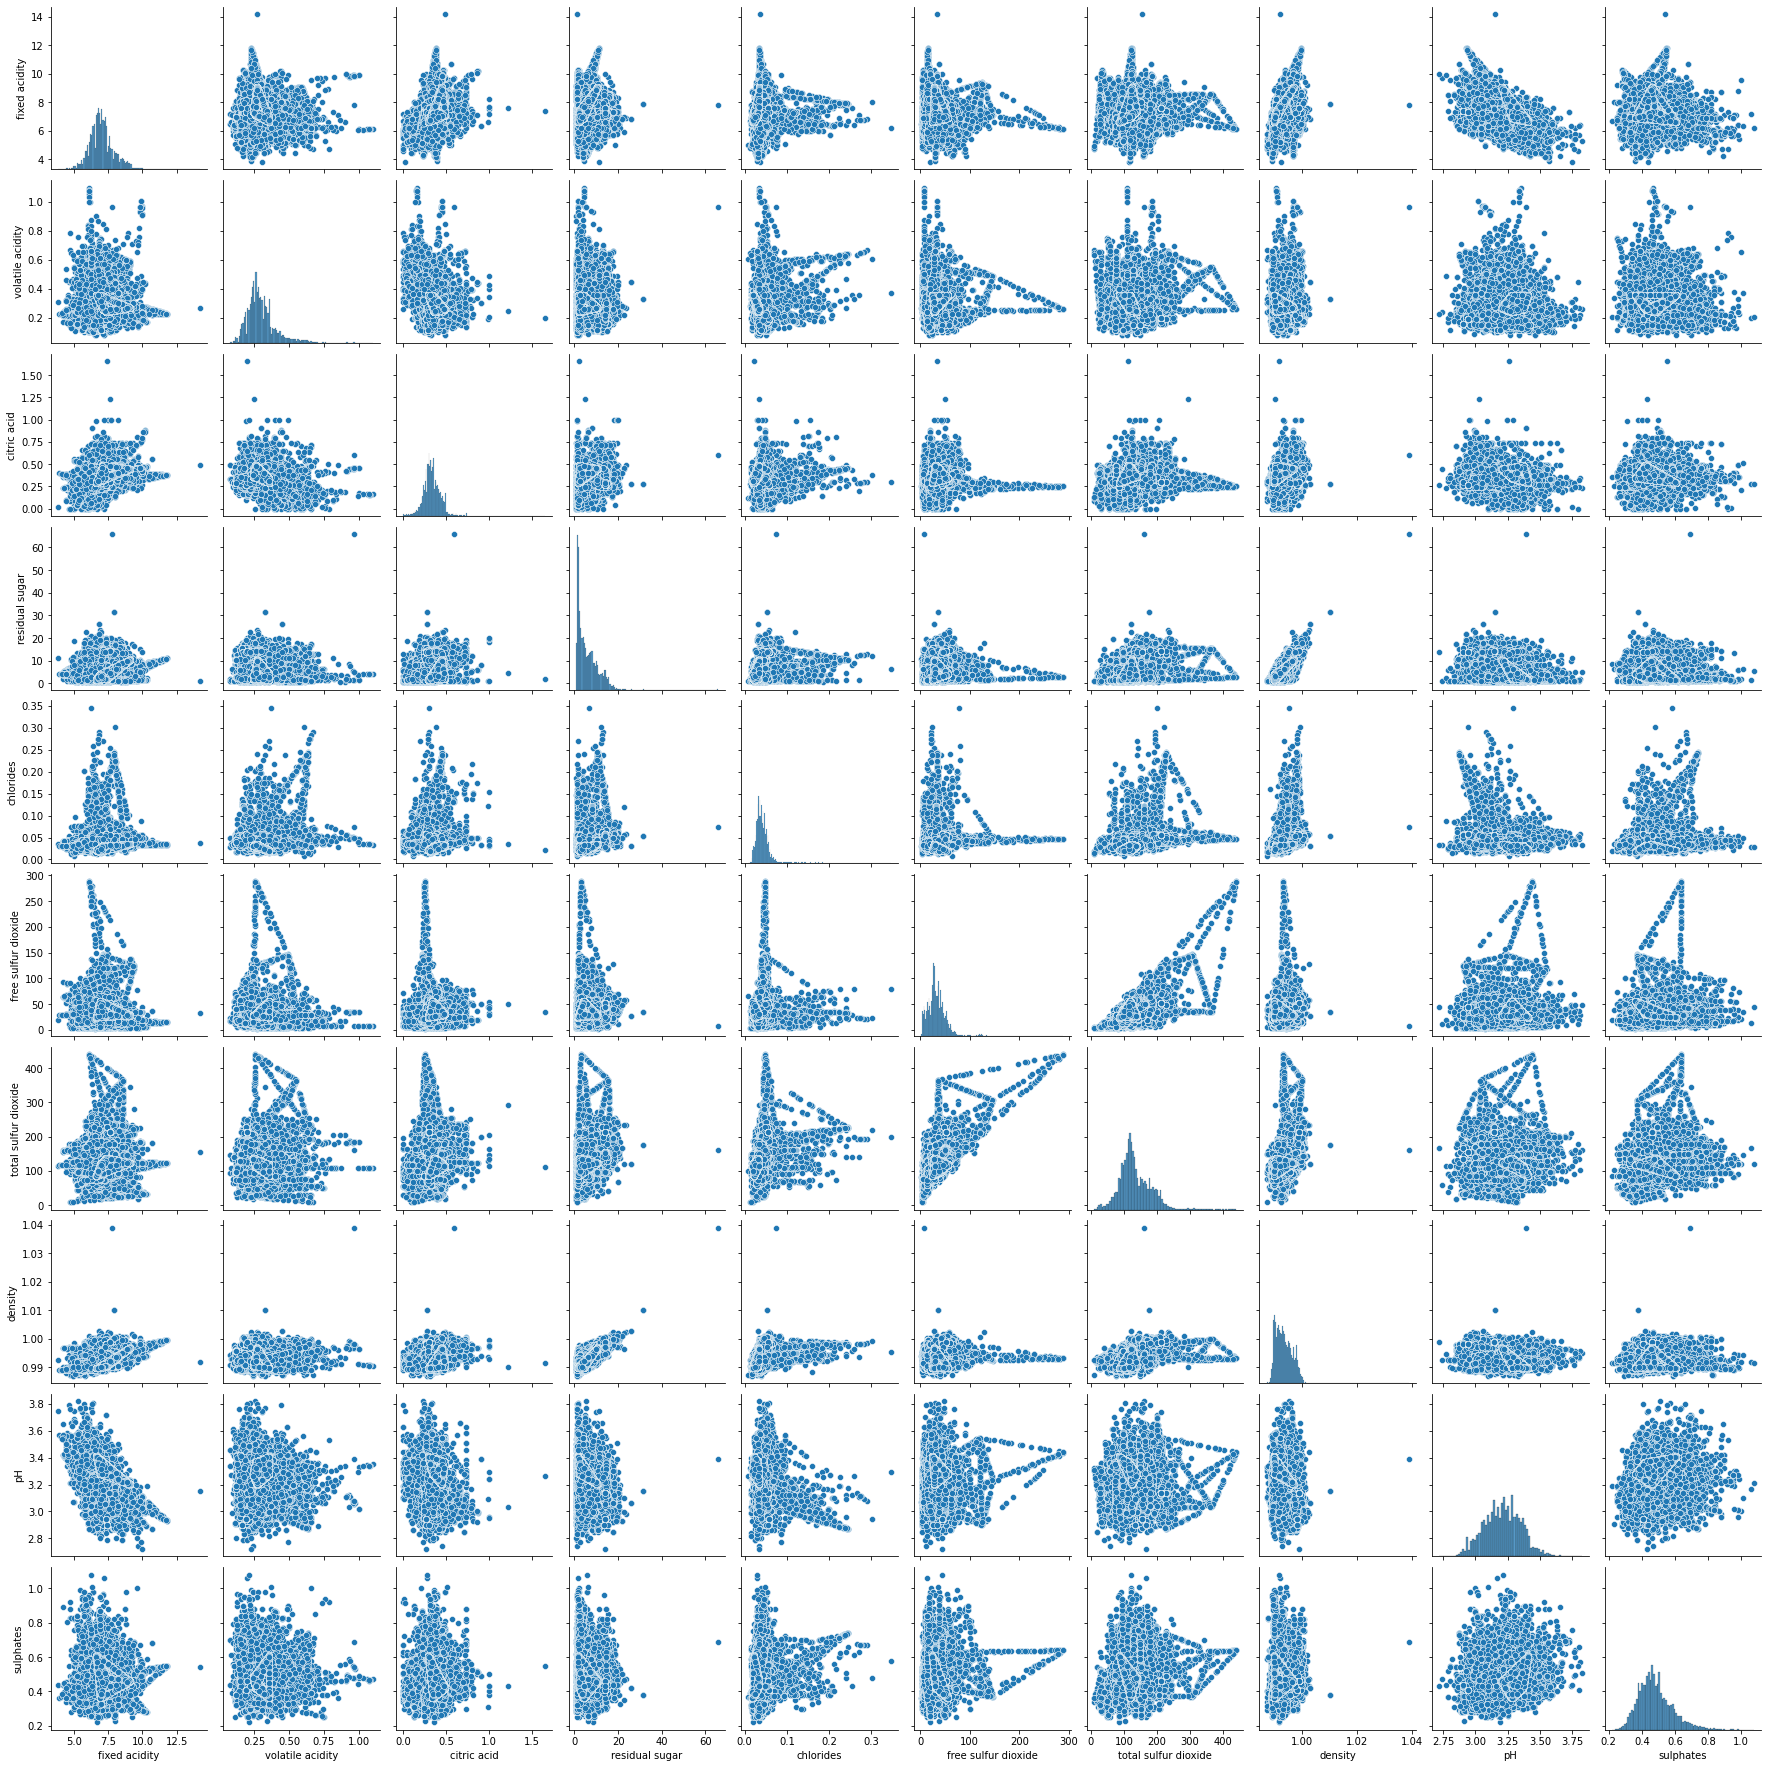

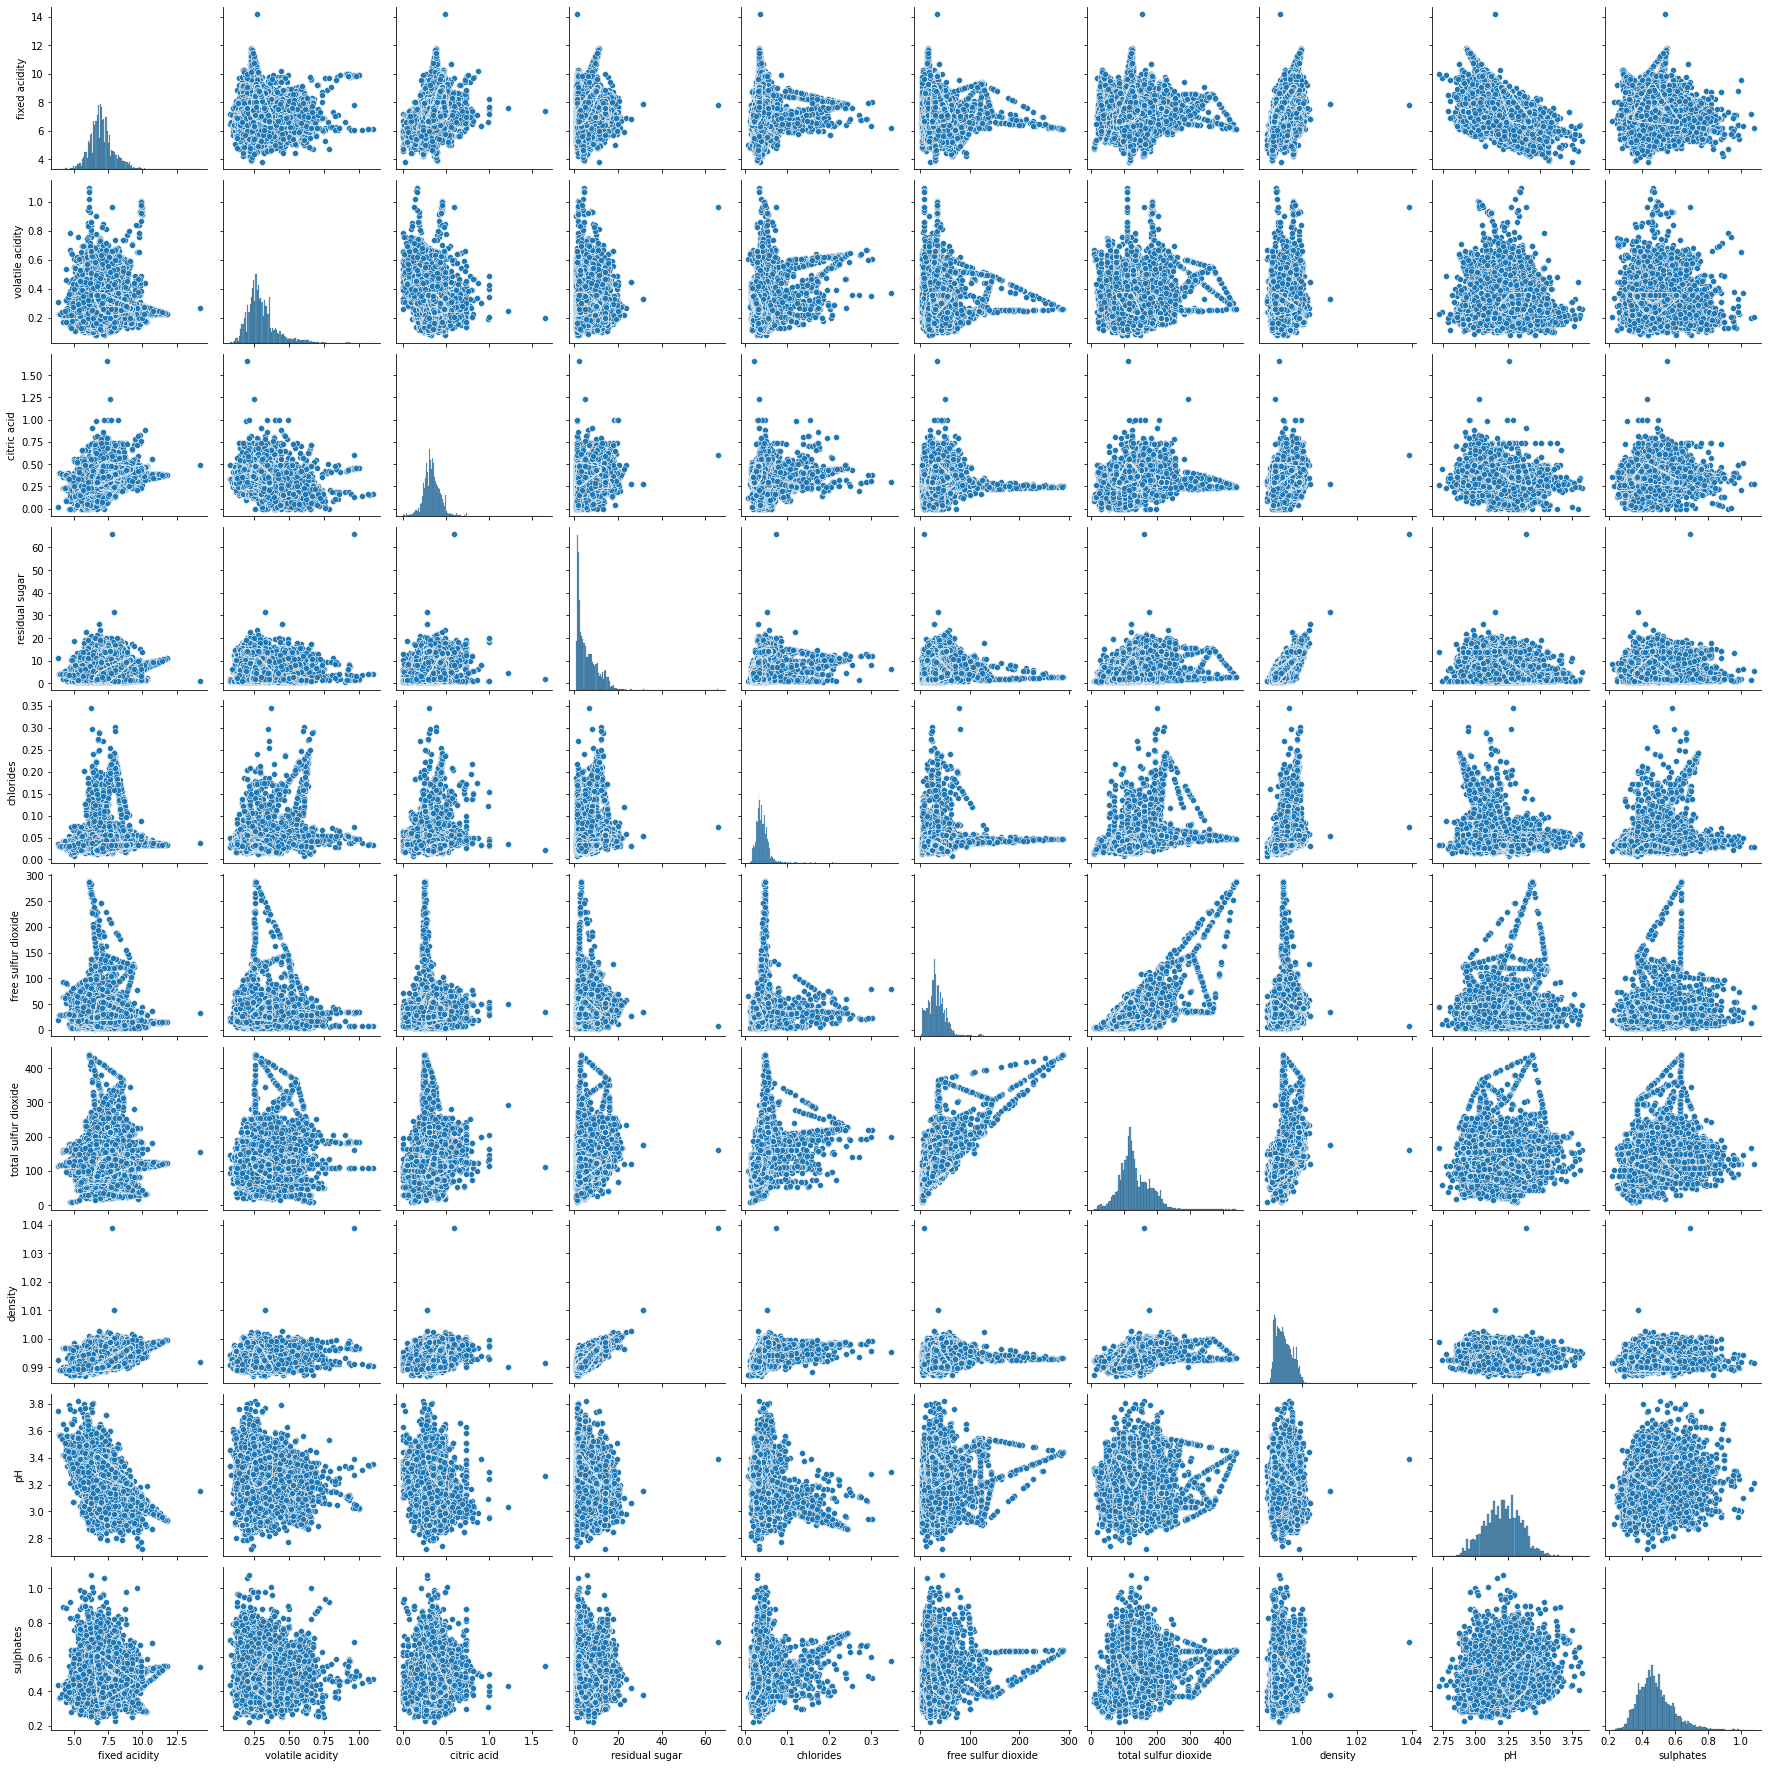

In [19]:
for index, df in enumerate(white_wine_oversampling_df):
    print(oversampling_technique_names[index])
    sns.pairplot(df)
    plt.show()
    